# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

  - Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
  - Контролировать добросовестность кассиров при продаже алкоголя.
  
Необходимо построить модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

Начнём с импорта необходимых библиотек и распаковки файлов. Посмотрим общее содержимое, проверим на наличие пропусков.

In [1]:
# Импорт необходимых библиотек:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from tensorflow.keras.layers import Dense, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50

In [2]:
# Распаковка файла:
data = pd.read_csv('/datasets/faces/labels.csv')
print('Размер датасета -', data.shape)
print('***')
print(data.info())

Размер датасета - (7591, 2)
***
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB
None


Датасет из 2 столбцов и 7591 строки, типы данных корректны, пропусков нет.

Проведём небольшой исследовательский анализ: посмотрим на распределение возраста у покупателей, чтобы обозначить целевую категорию.

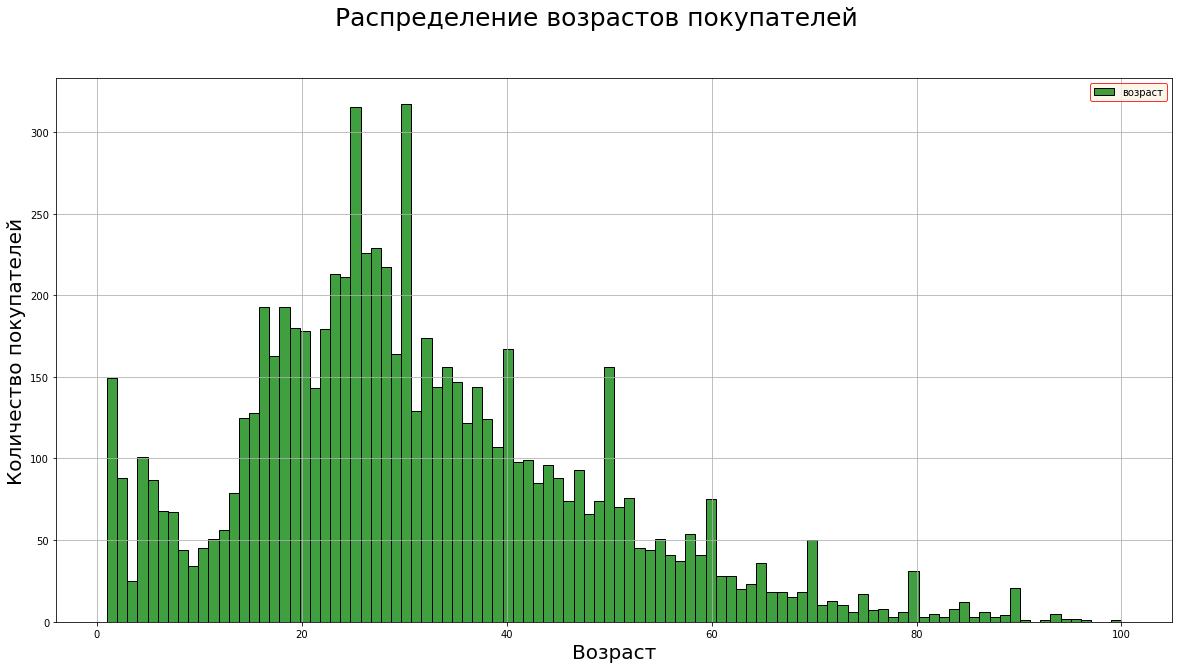

In [3]:
# Гистограмма по возрастам:
plt.figure(figsize=[20, 10])
plt.suptitle('Распределение возрастов покупателей', fontsize=25)
sns.histplot(data=data['real_age'], color='g', label='возраст', bins=100, kde=False)
plt.xlabel('Возраст', fontsize=20)
plt.ylabel('Количество покупателей', fontsize=20)
plt.grid(True)
plt.legend(edgecolor = 'r', facecolor = 'oldlace')
plt.show();

"Нормальным" распределение явно не назовёшь. Видно смещение влево, а также выбросы.

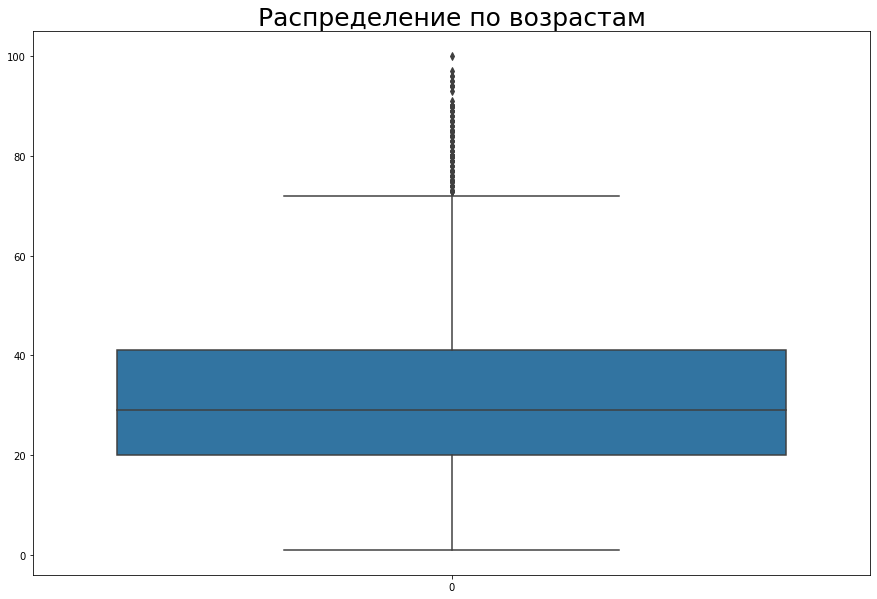

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

In [4]:
# Boxplot распределения:
plt.figure(figsize=[15, 10])
plt.title(f'Распределение по возрастам', fontsize=25)
sns.boxplot(data=data['real_age'])
plt.show()

data['real_age'].describe()

Покупатели за 70 являются редкостью. Интересно, почему они не ходят в магазин? Может быть стоит ввести акции для этой возрастной категории? Среднее и медианное значения примерно совпадают (31 и 29 лет).

#### Промежуточный вывод:
Данные распакованы и проверены, никаких преобразований не требуется.

Проведён небольшой исследовательский анализ в ходе которого выявили следующее:

  - основной костяк покупателей это люди от 20 до 40 лет, их абсолютное большинство;
  - средний и медианный возраст около 30 лет;
  - покупатели за 70 являются редкостью, стоит проанализировать, почему так.

Теперь загрузим файл с самими фотографиями, посмотрим на его содержимое.

In [5]:
# Загрузка фотографий:
df_datagen = ImageDataGenerator(rescale = 1./255)
df_datagen_flow = df_datagen.flow_from_dataframe(dataframe=data,
                                                       directory='/datasets/faces/final_files/',
                                                       x_col='file_name',
                                                       y_col='real_age',
                                                       target_size=(224,224),
                                                       batch_size=32,
                                                       class_mode='raw',
                                                       seed = 12345)

Found 7591 validated image filenames.


In [7]:
# Делим данные:
features, target = next(df_datagen_flow)
print('Размер выборки:', features.shape)

Размер выборки: (32, 224, 224, 3)


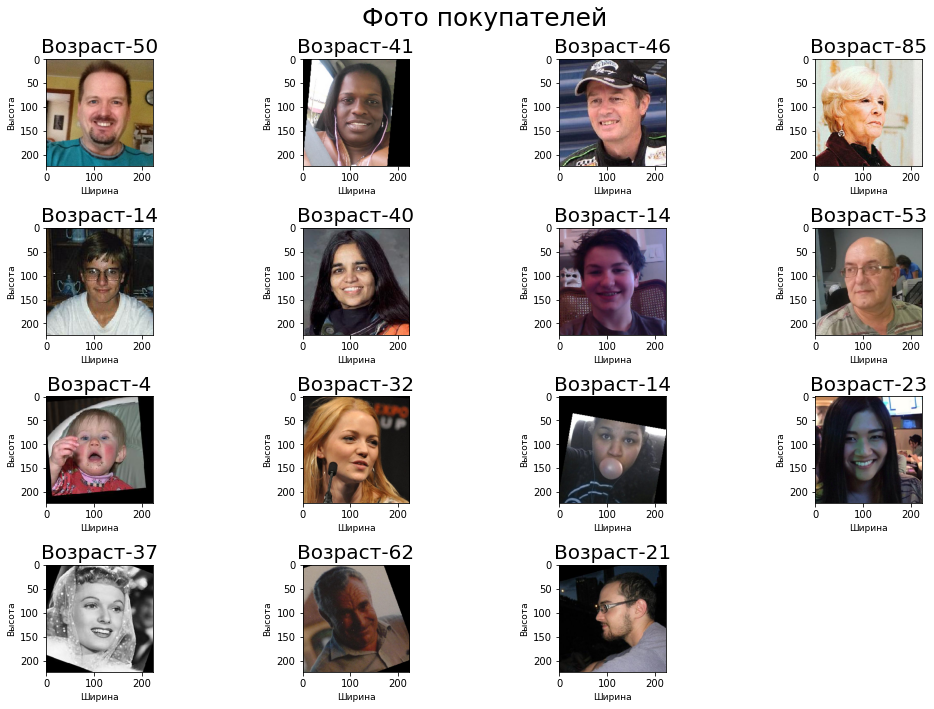

In [8]:
# Выведем первые 15 фотографий:
fig = plt.figure(figsize=(15,10))
plt.subplots_adjust(top=0.90, wspace=0.3, hspace=0.95)

for i in range(15):
    plt.suptitle('Фото покупателей', fontsize=25)
    fig.add_subplot(4,4, i+1)
    plt.title(f'Возраст-{target[i]}', fontsize=20)
    plt.imshow(features[i])
    plt.grid(False)
    plt.ylabel('Высота', fontsize=9)
    plt.xlabel('Ширина', fontsize=9)
    
plt.tight_layout()

Фотографии разного качества.

### Вывод:
Для работы предоставлены 2 файла: файл с информацией о возрасте и папка с самими фотографиями.

Данные распакованы и проверены, никаких преобразований не требуется.

Проведён небольшой исследовательский анализ в ходе которого выявили следующее:

  - основной костяк покупателей это люди от 20 до 40 лет, их абсолютное большинство;
  - средний и медианный возраст около 30 лет;
  - покупатели за 70 являются редкостью, стоит проанализировать, почему так.
  
Сами фотографии имеют разное качество: некоторые повёрнуты, некоторые в профиль, какие-то чёрно-белые, другие цветные.

## Обучение модели

Теперь напишем код для обучения модели. Обучать будем с помощью нейронной сети, используя аугментацию и ResNet. По условиям задачи качество модели будем измерять по MAE (значение не больше 8, будет лучше, если получится меньше 7).

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python
# Для тренировочной выборки:
def load_train(path):
    df = pd.read_csv(path+'labels.csv')
    train_datagen = ImageDataGenerator(rescale=1/255.,
                                       validation_split=0.25,
                                       horizontal_flip=True,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2)
    train_datagen_flow = train_datagen.flow_from_dataframe(dataframe=df,
                                                           directory=path+'/final_files',    
                                                           x_col='file_name',
                                                           y_col='real_age',
                                                           target_size=(224,224),
                                                           batch_size=32,
                                                           class_mode='raw',
                                                           subset='training',  
                                                           seed = 12345)
    return train_datagen_flow

# То же самое для тестовой выборки:
def load_test(path):
    df = pd.read_csv(path+'labels.csv')
    test_datagen = ImageDataGenerator(rescale=1/255.,
                                      validation_split=0.25)
    test_datagen_flow = test_datagen.flow_from_dataframe(dataframe=df,
                                                         directory=path+'/final_files',
                                                         x_col='file_name',
                                                         y_col='real_age',
                                                         target_size=(224,224),
                                                         batch_size=32,
                                                         class_mode='raw',
                                                         subset='validation',     
                                                         seed = 12345)
    return test_datagen_flow

# Функция создания модели с ResNet и ImageNet:
def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape, 
                        weights='imagenet',
                        include_top=False)
    
    optimizer = Adam(lr=0.0001)
    
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])

    return model

# Функция обучения модели:
def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
        
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)
    
    return model

```

```

Found 5694 validated image filenames.
Found 1897 validated image filenames.

    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 178 steps, validate for 60 steps
Epoch 1/10
178/178 - 124s - loss: 241.8485 - mae: 11.0470 - val_loss: 640.7462 - val_mae: 20.3298
Epoch 2/10
178/178 - 92s - loss: 91.6595 - mae: 7.2131 - val_loss: 594.6199 - val_mae: 19.3338
Epoch 3/10
178/178 - 91s - loss: 73.2236 - mae: 6.5102 - val_loss: 288.7849 - val_mae: 12.6466
Epoch 4/10
178/178 - 91s - loss: 59.6825 - mae: 5.8976 - val_loss: 129.0837 - val_mae: 8.5474
Epoch 5/10
178/178 - 94s - loss: 47.9533 - mae: 5.2929 - val_loss: 90.2538 - val_mae: 7.2510
Epoch 6/10
178/178 - 95s - loss: 43.1685 - mae: 5.0441 - val_loss: 70.1440 - val_mae: 6.1546
Epoch 7/10
178/178 - 95s - loss: 36.9501 - mae: 4.7005 - val_loss: 70.0270 - val_mae: 6.0601
Epoch 8/10
Found 5694 validated image filenames.
Found 1897 validated image filenames.
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 178 steps, validate for 60 steps
Epoch 1/10
178/178 - 124s - loss: 241.8485 - mae: 11.0470 - val_loss: 640.7462 - val_mae: 20.3298
Epoch 2/10
178/178 - 92s - loss: 91.6595 - mae: 7.2131 - val_loss: 594.6199 - val_mae: 19.3338
Epoch 3/10
178/178 - 91s - loss: 73.2236 - mae: 6.5102 - val_loss: 288.7849 - val_mae: 12.6466
Epoch 4/10
178/178 - 91s - loss: 59.6825 - mae: 5.8976 - val_loss: 129.0837 - val_mae: 8.5474
Epoch 5/10
178/178 - 94s - loss: 47.9533 - mae: 5.2929 - val_loss: 90.2538 - val_mae: 7.2510
Epoch 6/10
178/178 - 95s - loss: 43.1685 - mae: 5.0441 - val_loss: 70.1440 - val_mae: 6.1546
Epoch 7/10
178/178 - 95s - loss: 36.9501 - mae: 4.7005 - val_loss: 70.0270 - val_mae: 6.0601
Epoch 8/10
178/178 - 94s - loss: 32.4649 - mae: 4.3985 - val_loss: 126.5000 - val_mae: 8.4068
Epoch 9/10
178/178 - 101s - loss: 28.8536 - mae: 4.1432 - val_loss: 70.6226 - val_mae: 6.1285
Epoch 10/10
178/178 - 97s - loss: 24.4941 - mae: 3.8320 - val_loss: 88.8976 - val_mae: 6.6562
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 10s - loss: 88.8976 - mae: 6.6562

```

## Анализ обученной модели

Модель справилась с поставленной задачей, метрика MAE = 6.6 на тестовой выборке, что говорит о достижении отличного результата. 

Для конструкции самой модели потребовалось использовать архитектуру ResNet (вместе с набором фотографий ImageNet), аугментацию тренировочной выборки, а также Adam с уменьшенным шагом.

Скорость обучения модели сносная, количество эпох можно сократить на 1, так как уже на 9-ой был отличный результат.

## Итоговый вывод:

Для работы были предоставлены 2 файла: файл с информацией о возрасте и файл с самими фотографиями.

Данные распакованы и проверены, никаких преобразований не требуется.

Проведён небольшой исследовательский анализ в ходе которого выявили следующее:

  - основной костяк покупателей это люди от 20 до 40 лет, их абсолютное большинство;
  - средний и медианный возраст около 30 лет;
  - покупатели за 70 являются редкостью, стоит проанализировать, почему так.
  
Сами фотографии имеют разное качество: некоторые повёрнуты, некоторые в профиль, какие-то чёрно-белые, другие цветные.

Модель МО была обучено с помощью нейронной сети.

Итоговая модель справилась с поставленной задачей, метрика MAE = 6.6 на тестовой выборке, что говорит о достижении отличного результата.

Для конструкции самой модели потребовалось использовать архитектуру ResNet (вместе с набором фотографий ImageNet), аугментацию тренировочной выборки, а также Adam с уменьшенным шагом.

Скорость обучения модели сносная, количество эпох можно сократить на 1, так как уже на 9-ой был отличный результат.

Работа выполнена в полном объёме, требуемый результат достигнут, дополнительных исследований не требуется (кроме момента с пожилыми покупателями, дайте им скидки!).